# Accessing and Processing the Optical Absorption and Attenuation (OPTAA) Data from OOI

OOI uses the [Sea-Bird Electronics, AC-S In-Situ Spectrophotometer](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) to measure the in situ absorption and beam attenuation coefficients from approximately 400 to 750 nm at a 4 nm resolution. Each sensor is equipped with a unique filter set that determines the exact wavelengths measured and the total number of wavelengths measured. This difference in the number of measured wavelengths and, to a certain extent, their specific values can cause complications when trying to compare measurements across deployments. One solution, presented here, is to reset the number of wavelengths for each unique instrument/deployment instance using fill values to pad out the number of wavelengths and the absorption and beam attenuation measurements to a fixed number of wavelengths. This creates a common dimension for the number of wavelengths that can be used when subsequently concatenating data across deployments.

An additional issue is the volume of data produced by the sensor. A full deployment's worth of data can get rather unwieldy. Per a recommendation from the vendor, the first 60 seconds worth of data should be discarded after an instrument starts up. Dropping those records will help to reduce the volume of the data. We can also use burst averaging to further reduce the volume. Burst averaging has an added benefit in helping to reduce some of the point-to-point noisiness that is common in bio-optical data (biology is messy!).

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import get_vocabulary, load_kdata
from ooi_data_explorations.uncabled.process_optaa import optaa_datalogger

from matplotlib import pyplot as plt

For this example, we'll look at the data from Deployment 3 of the Oregon Shelf Surface Mooring. The instrument failed after approximately 8 weeks into the deployment, so this is not a full deployments worth of data. This particular instrument is run once an hour for 2-4 minutes at ~4 Hz. Each measurement cycle represents a burst measurement.

Rather than requesting the data from the M2M interface, we'll request the data from the [OOI Gold Copy THREDDS server](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/catalog.html). This data is pulled from the M2M system by automated processes on a regular schedule, and is used as the backend data source for [Data Explorer](https://dataexplorer.oceanobservatories.org/). Pulling this pre-computed and organized data, compared to issuing an M2M data request, waiting while the data is collected and processed, and then downloading the results, can represent a significant time-savings for the researcher (on the order of hours for some of the larger, more complex data sets). The functions used to access the data from the Gold Copy can be found in the python section of the [OOI Data Explorations](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python) GitHub repository.

In [2]:
# Setup needed parameters for the request
site = 'CE02SHSM'           # OOI Net site designator
node = 'RID27'              # OOI Net node designator
sensor = '01-OPTAAD000'     # OOI Net sensor designator
stream = 'optaa_dj_dcl_instrument_recovered'  # OOI Net stream name
method = 'recovered_host'   # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 3

# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*OPTAA*.nc' % deploy))

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

Loading and Processing Data Files: 100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


The OOI OPTAA data sets do not include data products from the intermediate optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity 
- the data has been has been corrected for the effects of temperature and salinity, but the scattering correction has not been applied to the optical absorption data
- the optical absorption data has been corrected for effects of scattering (this example utilizes the baseline scatter correction method)

It is considered good practice to make these intermediate data products available to users, especially more advanced users wishing to assess different methods for the scatter corrections. Additionally, if corrections to the spectra are required, using offsets determined by pre-deployment calibrations, these intermediate data products will be needed.

The `process_optaa` module has been set up to recalculate these intermediate products starting from the raw measurements. Additionally, the scattering correction has been switched to the simpler [Baseline Correction](https://ioccg.org/wp-content/uploads/2020/09/absorption_protocol_final-incl-cover_rev.pdf) method from the more complicated [modified proportional method](https://github.com/cwingard/ion-functions/blob/master/ion_functions/data/opt_functions.py#L508) employed by OOI.

In order to create these intermediate data products, we first need to download the calibration data for the instrument from the OOI Asset Management records accessible via the OOI M2M system. The `cal_file` variable created above will hold this data. The first time the calibration data is downloaded, this file will be created. After that, the code will reuse the already downloaded data.

In [3]:
optaa = optaa_datalogger(optaa, cal_file)

Calculating burst averages ...
... burst averaging complete.  Elapsed time: 7.895868 seconds


Converting attenuation data ...: 100%|██████████| 1287/1287 [00:00<00:00, 4430.33it/s]


In [4]:
optaa = optaa.sel(time=slice('2016-05-17T00:00:00', '2016-07-09T23:59:50'))
optaa

<xarray.Dataset>
Dimensions:                       (time: 1274, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 2016-05-17T22:30:00 ....
  * wavelength_number             (wavelength_number) int64 0 1 2 3 ... 97 98 99
Data variables: (12/33)
    external_temp_raw             (time) int64 38611 38717 38619 ... 36520 36636
    elapsed_run_time              (time) float64 1.173e+05 ... 1.169e+05
    internal_temp_raw             (time) int64 50047 50113 50052 ... 48830 48903
    c_reference_dark              (time) int64 471 471 471 472 ... 468 467 468
    sea_water_practical_salinity  (time) float64 31.88 31.89 ... 31.63 31.74
    deployment                    (time) int64 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 399.8 ......
    c_signal                      (time, wavelength_number) int64 633 ... -99...
    c_reference                   (time, wavelength_number) int64 739 ... -99...
    beam_attenuation              (time, wavelength_number) float64 nan ... nan
    cpg                           (time, wavelength_number) float64 1.396 ......
    cpg_ts                        (time, wavelength_number) float64 nan ... nan
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             optaa_dj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites.

Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, by computing different parameters (chlorophyll concentration, POC, and absorption ratios) from the absorption and attenuation records and by reviewing the shape and magnitude of the aborption and attenuation spectra.

In [5]:
nc_file = ('{}.{}.{}.deploy03.reprocessed.nc'.format(site.lower(), level, instrmt))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

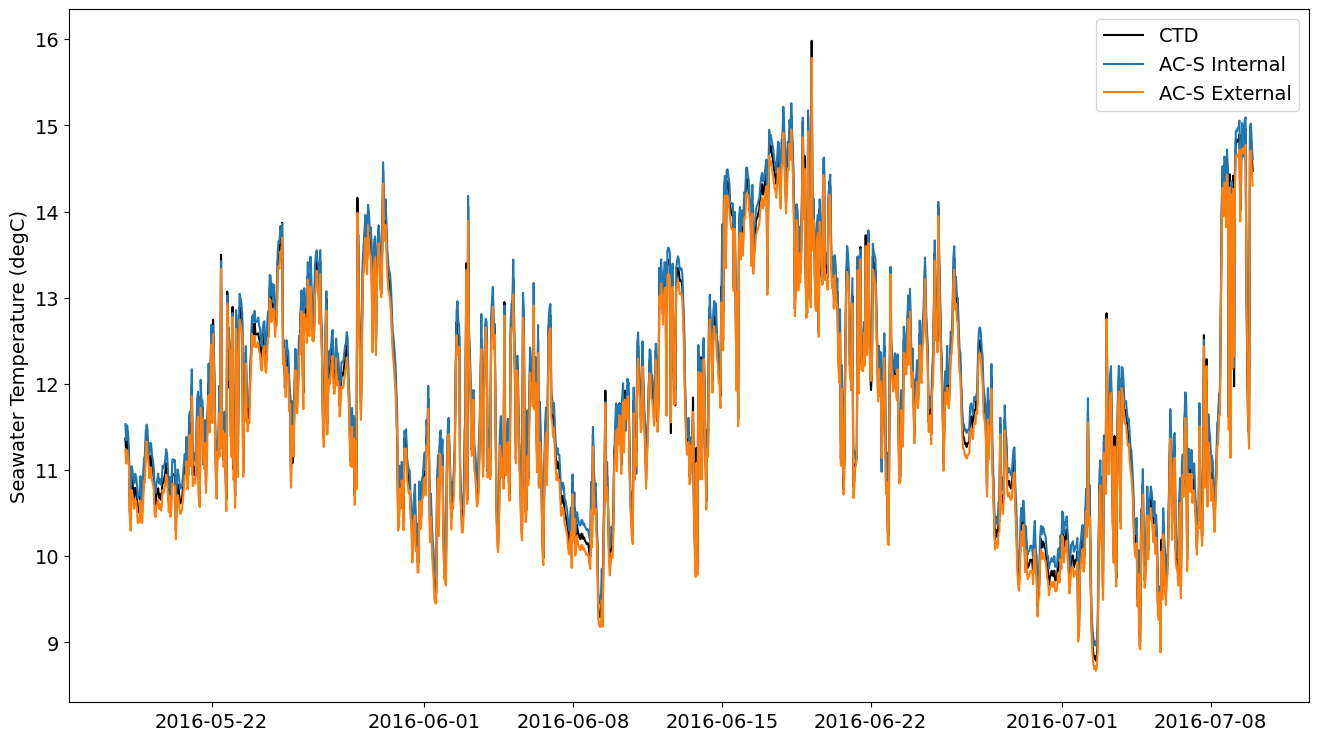

In [6]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(optaa['time'], optaa['sea_water_temperature'], '-k', label='CTD')
plt.plot(optaa['time'], optaa['internal_temp'], label='AC-S Internal')
plt.plot(optaa['time'], optaa['external_temp'], label='AC-S External')
plt.ylabel('Seawater Temperature (degC)')
plt.legend()

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used, but it should be producing values very close to the CTD (the AC-S temperaure sensor is not as accurate as the CTD). All three measurements should be very similar. If they are not, that would be a good indication that there is a problem with one of the sensors.

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors. Additionally, pigment ratios can be calculated to assess the impacts of biofouling, potential changes in community composition, light history or bloom health and age, .

* CDOM Ratio -- ratio of CDOM absorption in the violet portion of the spectrum at 412 nm relative to chlorophyll absorption at 440 nm. Ratios greater than 1 indicate a preponderance of CDOM absorption relative to chlorophyll.
* Carotenoid Ratio -- ratio of carotenoid absorption in the blue-green portion of the spectrum at 490 nm relative to chlorophyll absorption at 440 nm. A changing carotenoid to chlorophyll ratio may indicate a shift in phytoplankton community composition in addition to changes in light history or bloom health and age.
* Phycobilin Ratio -- ratio of phycobilin absorption in the green portion of the spectrum at 530 nm relative to chlorophyll absorption at 440 nm. Different phytoplankton, notably cyanobacteria, utilize phycobilins as accessory light harvesting pigments. An increasing phycobilin to chlorophyll ratio may indicate a shift in phytoplankton community composition.
* Q Band Ratio -- the Soret and the Q bands represent the two main absorption bands of chlorophyll. The former covers absorption in the blue region of the spectrum, while the latter covers absorption in the red region. A decrease in the ratio of the intensity of the Soret band at 440 nm to that of the Q band at 676 nm may indicate a change in phytoplankton community structure. All phytoplankton contain chlorophyll a as the primary light harvesting pigment, but green algae and dinoflagellates contain chlorophyll b and c, respectively, which are spectrally redshifted compared to chlorophyll a.

Before we look at the estimated chlorophyll and POC data, it will be helpful to pull in data from the co-located Sea-Bird Electronics ECO Triplet (FLORT). This data can also be used to create estimates of chlorophyll and POC, which can then be cross-compared to the AC-S estimates.

In [7]:
from ooi_data_explorations.uncabled.process_flort import flort_datalogger

# Setup needed parameters for the request
site = 'CE02SHSM'           # OOI Net site designator
node = 'RID27'              # OOI Net node designator
sensor = '02-FLORTD000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'recovered_host'   # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'flort'           # local directory name, instrument below level

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 3

# load data from the local kdata directory
flort = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*FLORT*.nc' % deploy))
flort = flort_datalogger(flort, burst=True)
flort = flort.sel(time=slice('2016-05-17T00:00:00', '2016-07-09T23:59:50'))

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 53607 * (flort['bback'] - flort['seawater_scattering_coefficient']) + 2.5  # derived from Cetinic et al., 2015

Loading and Processing Data Files: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


In [8]:
flort

<xarray.Dataset>
Dimensions:                                (time: 5078, stats: 3)
Coordinates:
  * time                                   (time) datetime64[ns] 2016-05-17T2...
  * stats                                  (stats) int32 0 1 2
Data variables: (12/28)
    estimated_chlorophyll_qc_results       (time) float64 29.0 29.0 ... 29.0
    fluorometric_cdom                      (time) float64 2.19 2.271 ... 2.433
    fluorometric_cdom_qc_executed          (time) float64 29.0 29.0 ... 29.0
    beta_700_qc_executed                   (time) float64 29.0 29.0 ... 29.0
    raw_cdom                               (time) float64 72.0 73.0 ... 75.0
    bback                                  (time) float64 0.004494 ... 0.003252
    ...                                     ...
    beta_700_qc_summary_flag               (time) float64 1.0 1.0 ... 3.0 3.0
    fluorometric_cdom_qc_summary_flag      (time) float64 1.0 1.0 ... 1.0 1.0
    fluorometric_cdom_burst_stats          (time, stats) float64 1.946 ... 0....
    estimated_chlorophyll_burst_stats      (time, stats) float64 2.072 ... 0.155
    beta_700_burst_stats                   (time, stats) float64 0.0005728 .....
    estimated_poc                          (time) float64 209.9 216.2 ... 143.6
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             flort_sample
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

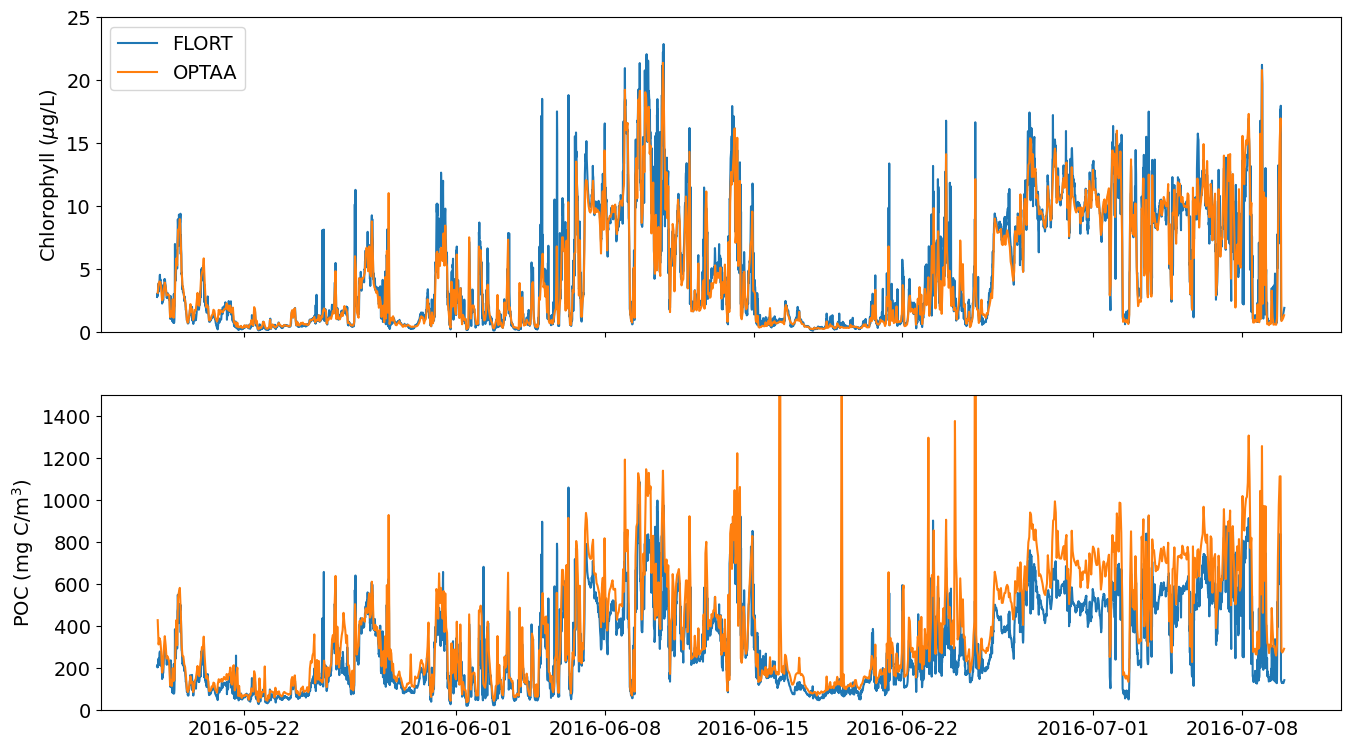

In [9]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(211)
plt.plot(flort['time'], flort['estimated_chlorophyll'], label='FLORT')
plt.plot(optaa['time'], optaa['estimated_chlorophyll'], label='OPTAA')
plt.ylabel('Chlorophyll ($\mu$g/L)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 25])
plt.legend(loc='upper left')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(flort['time'], flort['estimated_poc'])
plt.plot(optaa['time'], optaa['estimated_poc'])
plt.ylabel('POC (mg C/m$^3$)')
plt.ylim([0, 1500])
plt.show()

Note the excellent agreement between the AC-S and the ECO Triplet chlorophyll estimates, but the beginning of a divergence in the POC estimates towards the later quarter of the data set. This divergence suggests that biofouling might be starting to impact the AC-S measurements. The attenuation channel will usually be the most sensitive to the development of biofouling (the POC estimate is derived from then attenuation data).

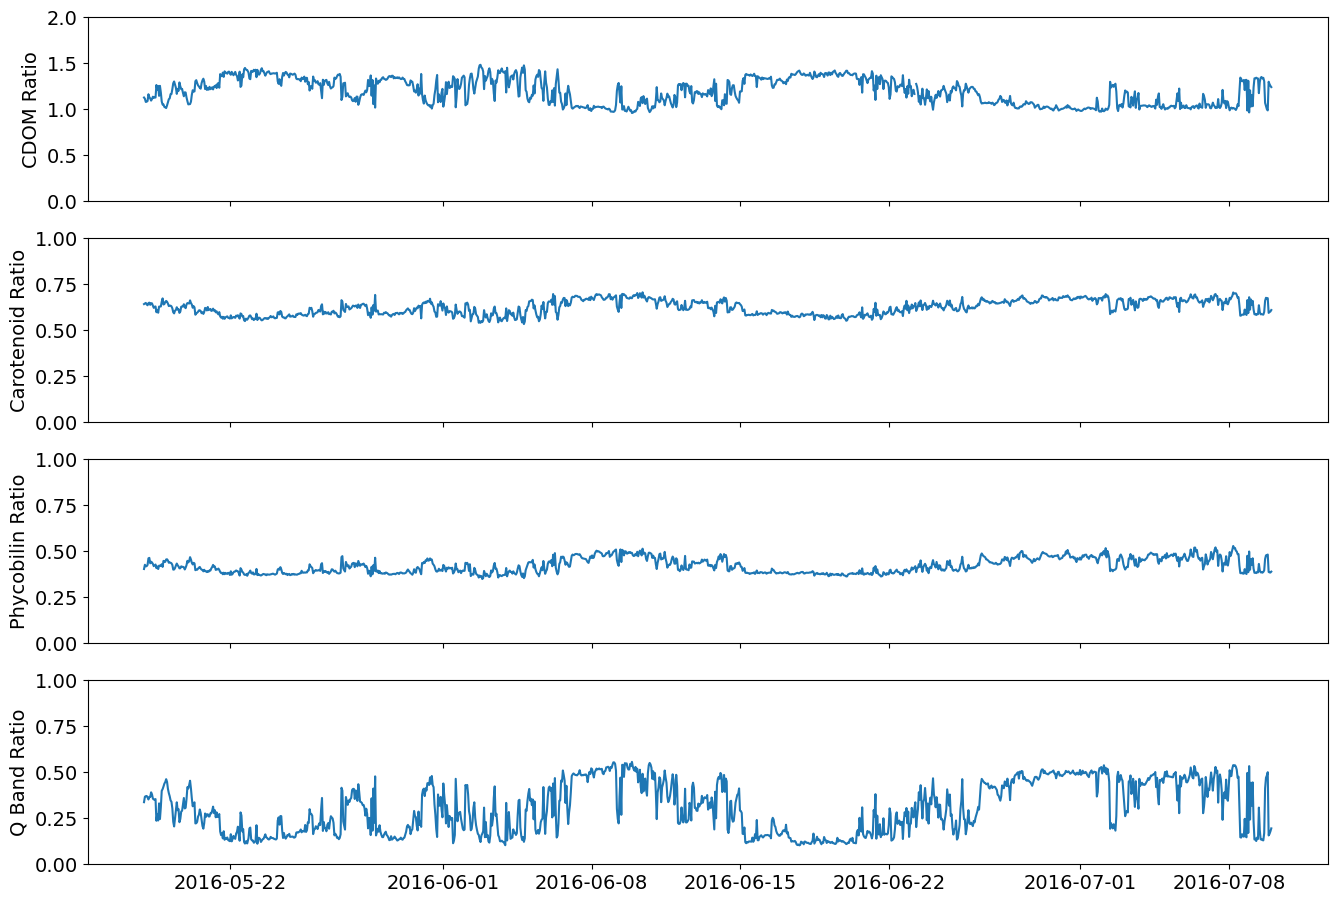

In [10]:
# plot the pigment ratios
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,11))

ax1 = plt.subplot(411)
plt.plot(optaa['time'], optaa['ratio_cdom'])
plt.ylabel('CDOM Ratio')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 2])

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_carotenoids'])
plt.ylabel('Carotenoid Ratio')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_phycobilins'])
plt.ylabel('Phycobilin Ratio')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_qband'])
plt.ylabel('Q Band Ratio')
plt.ylim([0, 1])

plt.show()

Finally, examining the shape and magnitudes of the absorption and attenuation spectra can be helpful in assessing the instrument performance in addition to revealing interesting information about the in situ absorption and attenuation properties of the seawater.

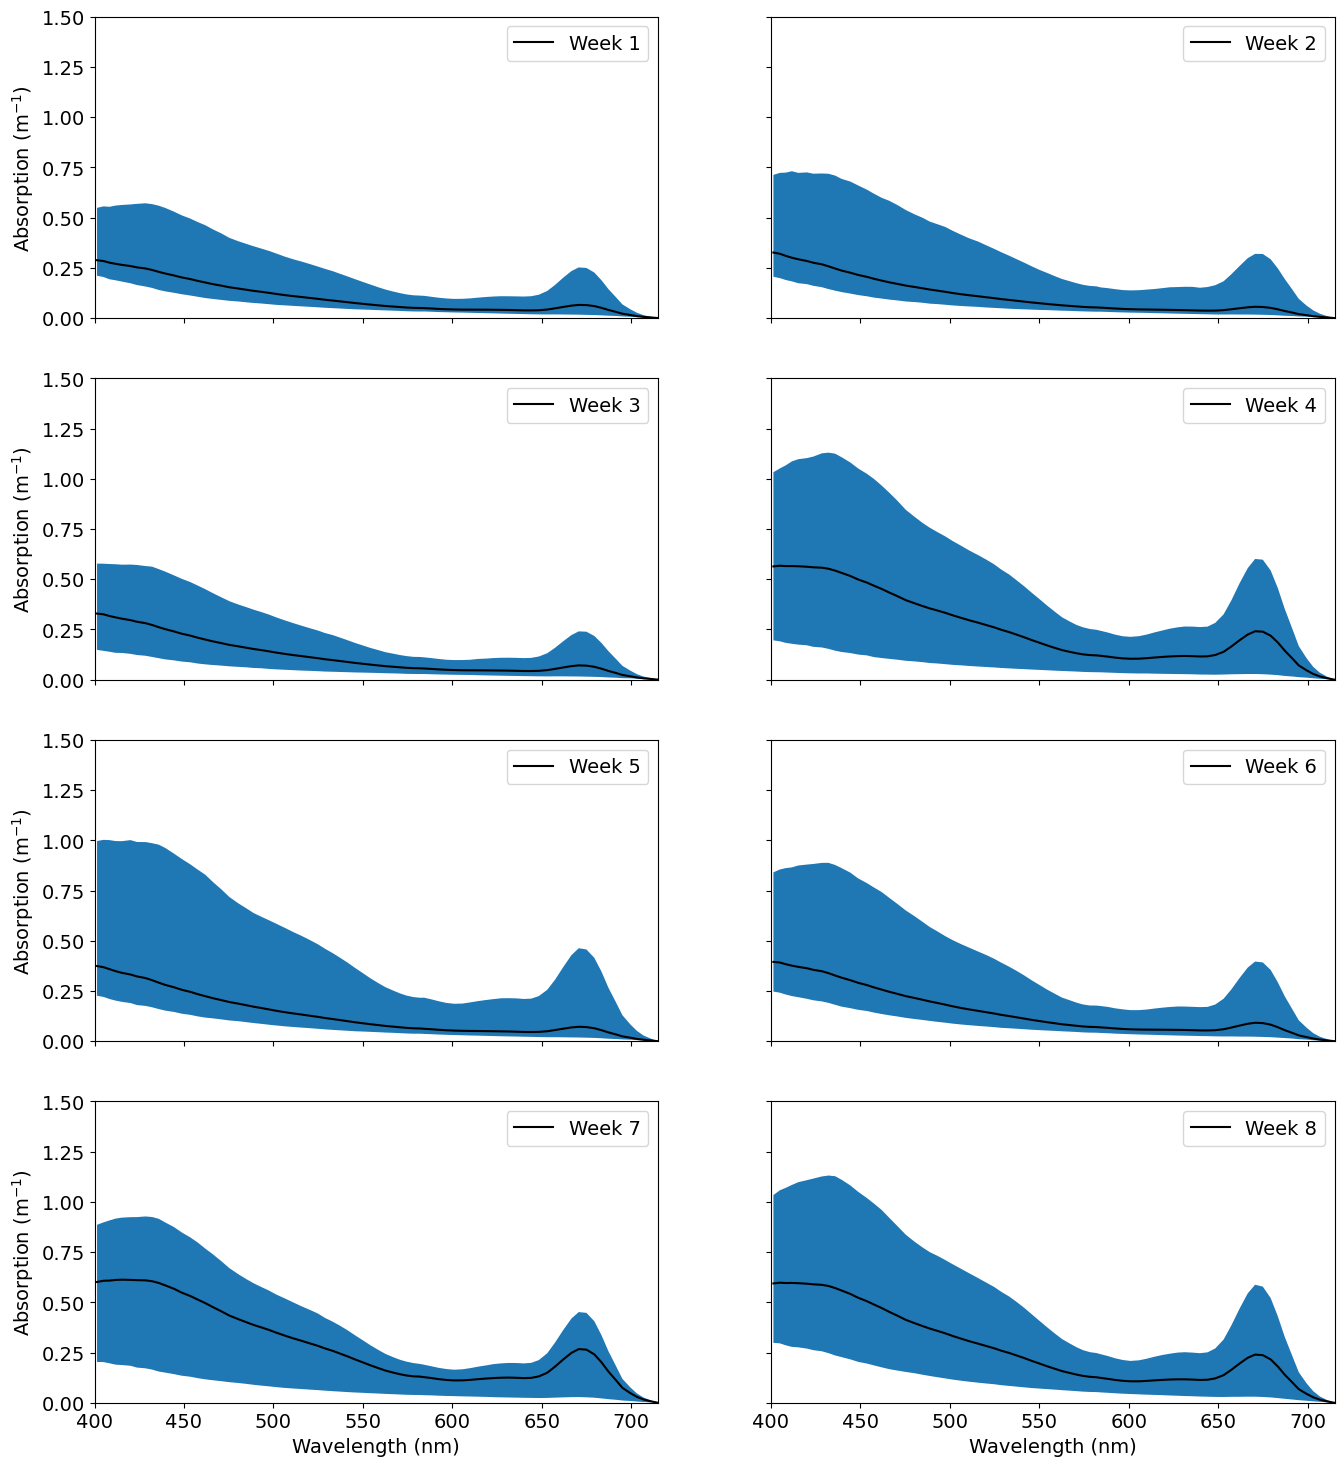

In [11]:
# create groups of data organized by the week
weeks = optaa.groupby('time.week').groups
nweek = [i for i,k in weeks.items()]

# plot weekly summaries of the absorption spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,18))

ax1 = plt.subplot(421)
week = optaa.isel(time=weeks[nweek[0]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 1')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.ylim([0, 1.5])
plt.ylabel('Absorption (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(422, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[1]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 2')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(423, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[2]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 3')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax4 = plt.subplot(424, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[3]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 4')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(425, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[4]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 5')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax6 = plt.subplot(426, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[5]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 6')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax7 = plt.subplot(427, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[6]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 7')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption (m$^{-1}$)')
plt.legend()

ax8 = plt.subplot(428, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[7]])
plt.plot(week['wavelength_a'][0, :], week['apg_ts_s'].mean(axis=0), '-k', label='Week 8')
plt.fill_between(week['wavelength_a'][0, :], week['apg_ts_s'].min(axis=0), week['apg_ts_s'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

plt.show()

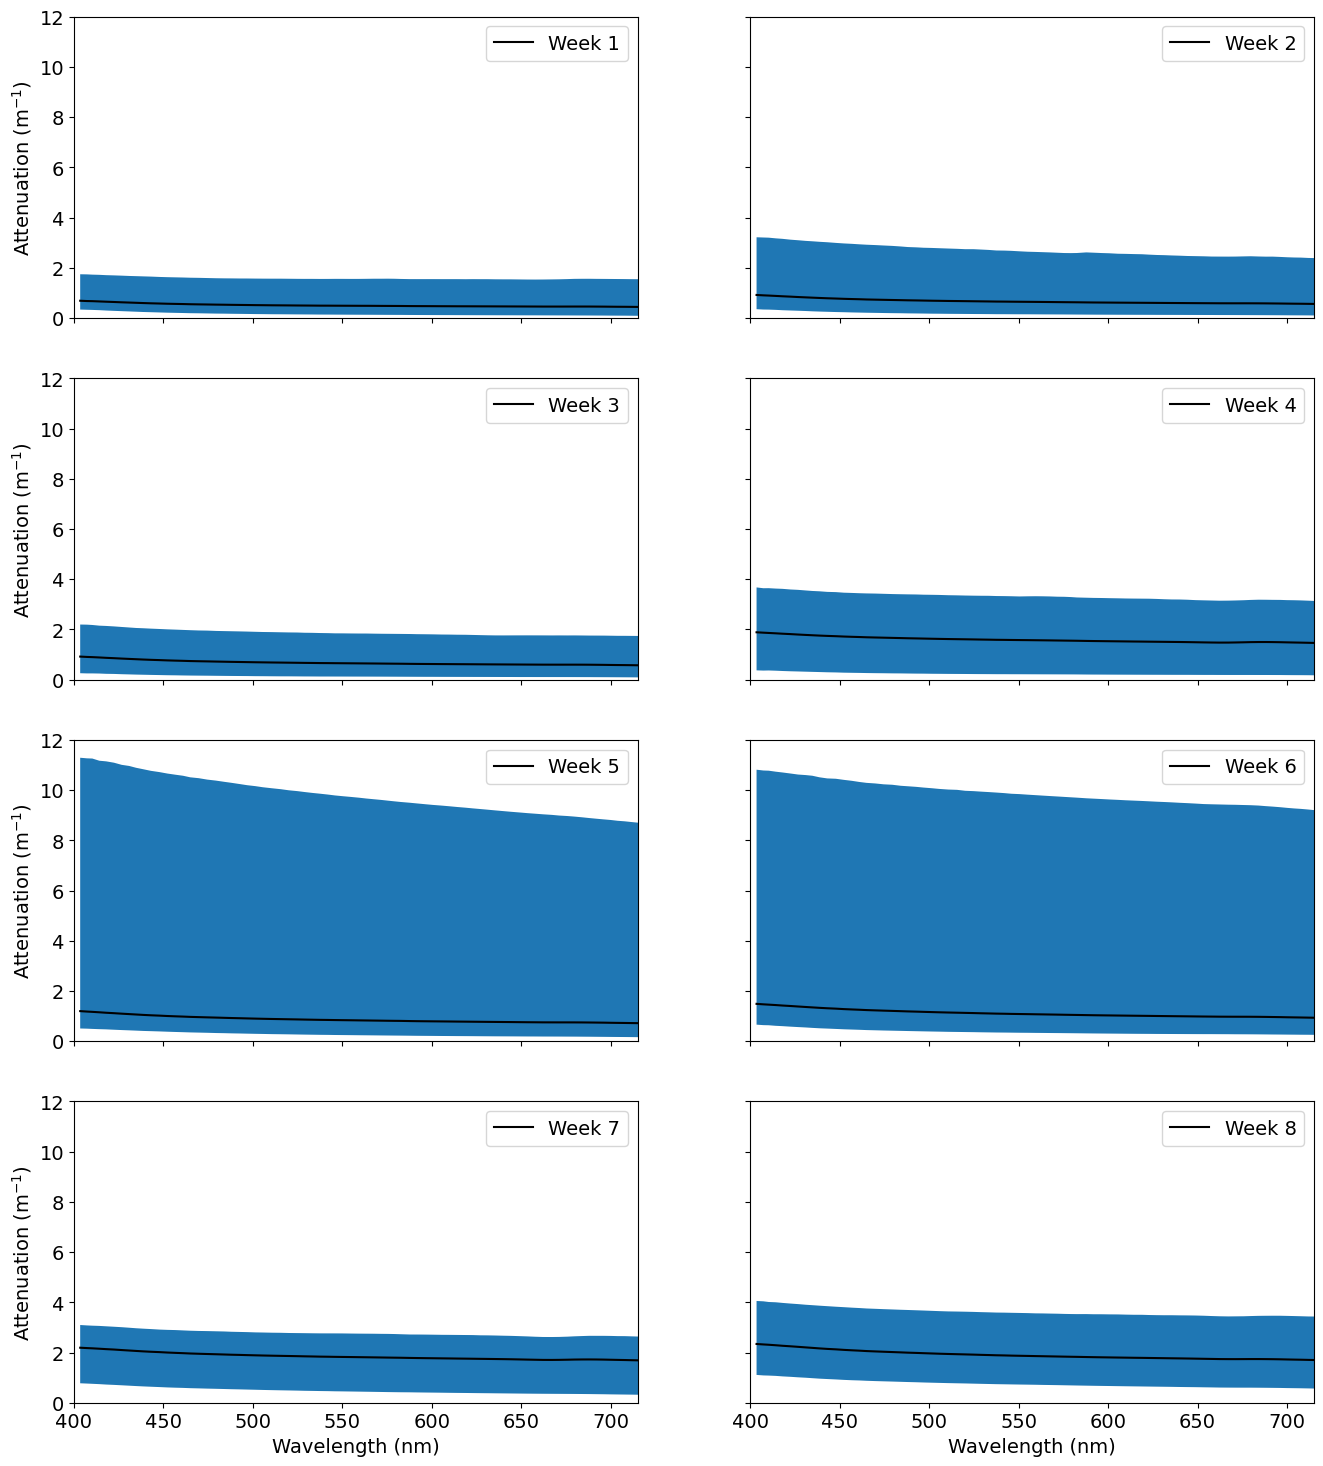

In [12]:
# plot weekly summaries of the attenuation spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,18))

ax1 = plt.subplot(421)
week = optaa.isel(time=weeks[nweek[0]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 1')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.ylim([0, 12])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(422, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[1]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 2')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(423, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[2]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 3')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax4 = plt.subplot(424, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[3]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 4')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(425, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[4]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 5')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax6 = plt.subplot(426, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[5]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 6')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax7 = plt.subplot(427, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[6]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 7')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.legend()

ax8 = plt.subplot(428, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[nweek[7]])
plt.plot(week['wavelength_c'][0, :], week['cpg_ts'].mean(axis=0), '-k', label='Week 8')
plt.fill_between(week['wavelength_c'][0, :], week['cpg_ts'].min(axis=0), week['cpg_ts'].max(axis=0))
plt.xlabel('Wavelength (nm)')
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

plt.show()